# Time Series Analysis of Tuberculosis in Brazil

This notebook contain a simple model of confirmed tuberculosis cases in Brazil, using AUTOARIMA and Prophet to predict 2020's cases. Soon we expected DATASUS to release 2020 dataset, so we will be able to compare our predicitons with real results.

Data Source: http://tabnet.datasus.gov.br/cgi/tabcgi.exe?sinannet/cnv/tubercbr.def


## Table of Contents

1.   Download and treat data
2.   Moving Average
3.   Autocorrelation and Decomposition
4.   SARIMA Model
5.   Prophet Model
6.   Comparison SARIMA x Prophet
7.   Prophet Hyperparameters Tuning
8.   Comparison SARIMA x Tuned Prophet
9.   My 2020 predictions


## 1.   Download and treat data

In [ ]:
!pip install pmdarima

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools

sns.set_style("darkgrid")

In [3]:
pathfile = '/content/drive/MyDrive/Series Temporais/tuberculose_ano_mes_diagnostico.csv'
df = pd.read_csv(pathfile, encoding = 'ISO-8859-1', sep = ';', skiprows =3 , skipfooter = 16, engine='python');

#Remove line and column with aggregated values
df.drop('Total',axis = 1,inplace=True)
df.drop(19,axis = 0,inplace=True)

In [4]:
df.head()

,Ano Diagnóstico,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
0,2001,8088,6542,8095,7305,7656,6805,6987,8065,6697,7524,6874,6627
1,2002,8013,7346,7961,8771,7784,6713,7746,8330,7654,8200,7532,6809
2,2003,8115,7985,7474,7975,8024,7082,7949,7585,8136,8521,7624,7303
3,2004,7574,6743,8574,8089,7763,7314,7825,8232,7901,8016,7753,7196
4,2005,7432,6748,8441,7958,8019,7781,7282,8391,7690,7186,7587,7541


We must melt the dataframe into a simple time serie and ensure proper datatypes assigned to each column.

In [5]:
ts = pd.melt(df, id_vars='Ano Diagnóstico',value_name='cases')

In [6]:
months = dict(zip(ts['variable'].unique(), [i for i in range (1,13)]))

ts.replace({'variable':months},inplace=True)

In [7]:
ts['date'] = ts['Ano Diagnóstico'].astype(str) + '-' + ts['variable'].astype(str) 
ts['date'] = pd.to_datetime(ts['date'])
ts = ts[['date','cases']].set_index('date')
ts = ts.asfreq('MS')
ts = ts.fillna(0)
ts.sort_index(inplace=True)

Now let's view the final serie we will be working with

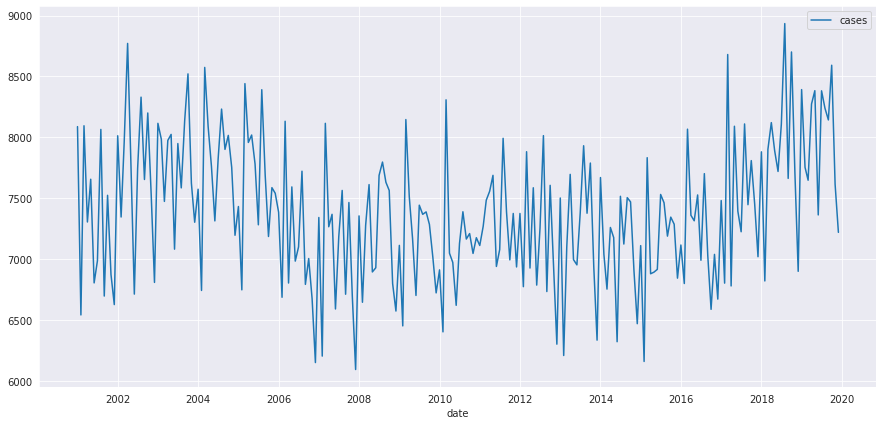

In [8]:
plt.figure(figsize=(15,7),facecolor='w')

sns.lineplot(data=ts)

We can easily spot some yearly sasonality with a growing trend in recent years.

## 2.   Moving Average

A possible method for predicting future values would be using a moving average. Let's compare moving average using different periods and see how that compares with our real data

In [9]:
ts_roll = ts.copy()

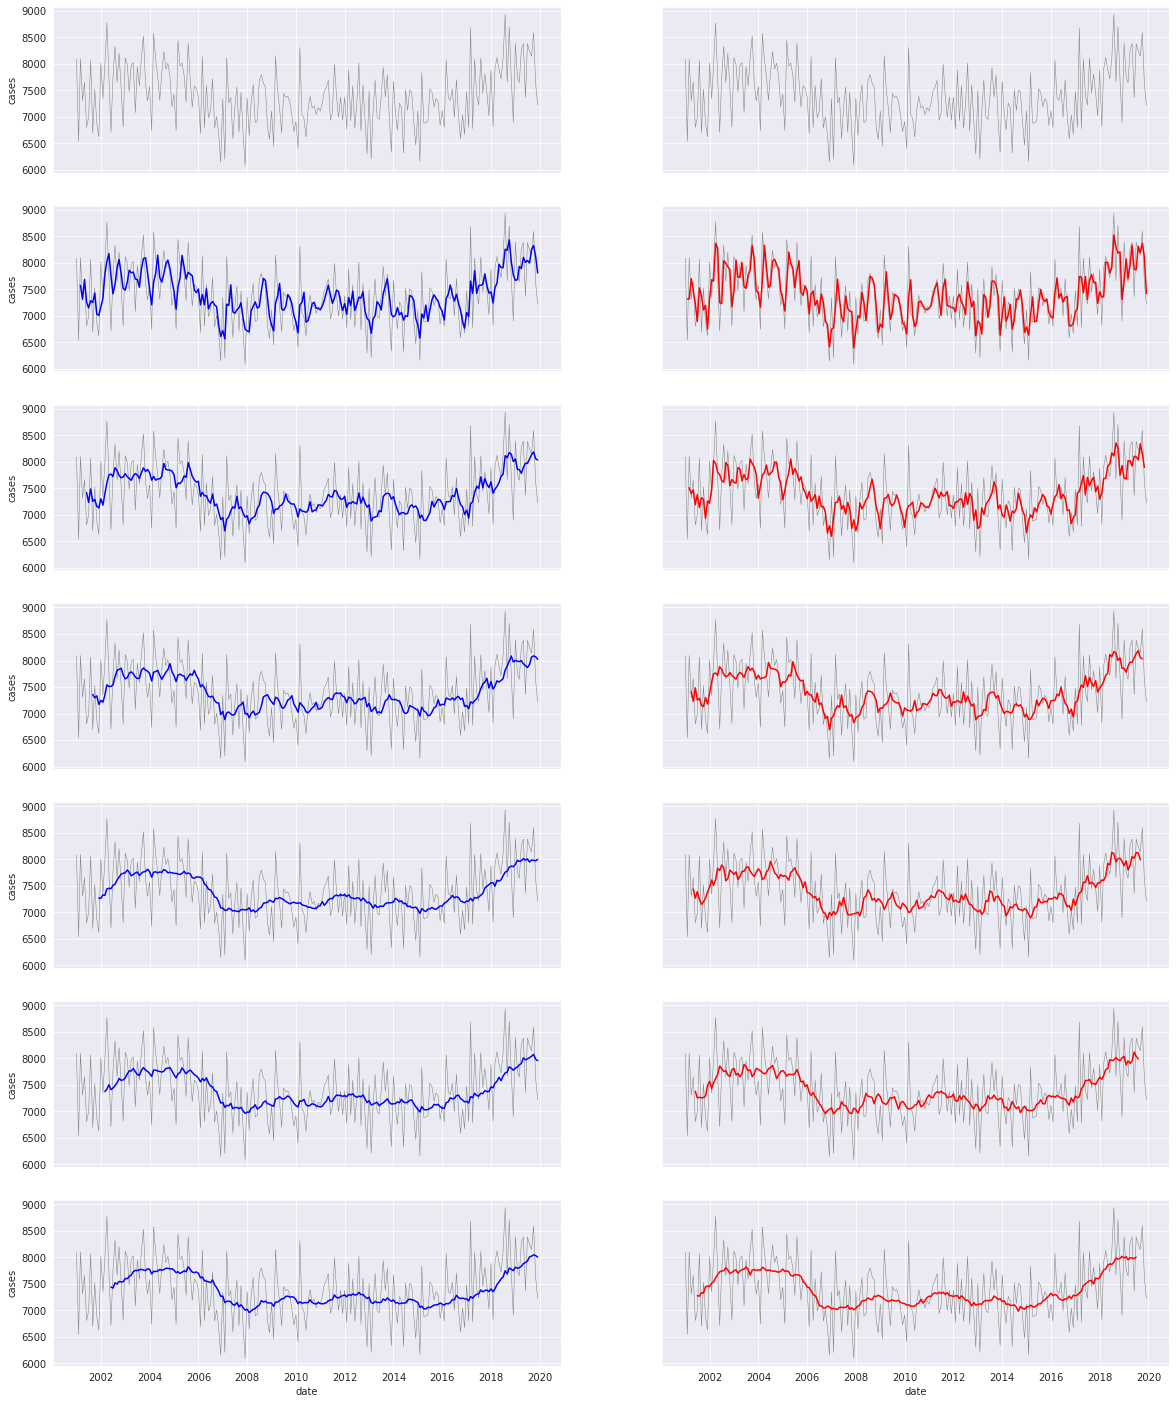

In [10]:
roll = 0
plots = 7
ctr = False

fig, axs = plt.subplots(plots,2, figsize = (20,25),facecolor='w', sharex = True,sharey=True)

while roll < plots:
  ts_roll['media_movel_'+str(roll)] = ts_roll['cases'].rolling(3*roll, center = False).mean()
  ts_roll['media_movel_'+str(roll)+'ctr'] = ts_roll['cases'].rolling(2*roll, center = True).mean()


  sns.lineplot(data=ts_roll,x='date',y='cases',ax=axs[roll,0],color= 'grey',linewidth = 0.5)
  sns.lineplot(data=ts_roll,x='date',y='media_movel_'+str(roll),ax=axs[roll,0],color= 'blue',linewidth = 1.5)
  
  sns.lineplot(data=ts_roll,x='date',y='cases',ax=axs[roll,1],color= 'grey',linewidth = 0.5)
  sns.lineplot(data=ts_roll,x='date',y='media_movel_'+str(roll)+'ctr',ax=axs[roll,1],color= 'red',linewidth = 1.5)
  roll +=1

Given the high variance in monthly cases, it is understandable that using only moving average will not return the best results for our predictions. Let's try a more in-depth technique.

##3.   Autocorrelation and Decomposition

We will attempt to decompose this timeseries to better understand its behavior. Given how to variance within a year stays stable, we will assume a additive model for our data.

In [11]:
decomp = seasonal_decompose(ts,model='additive')

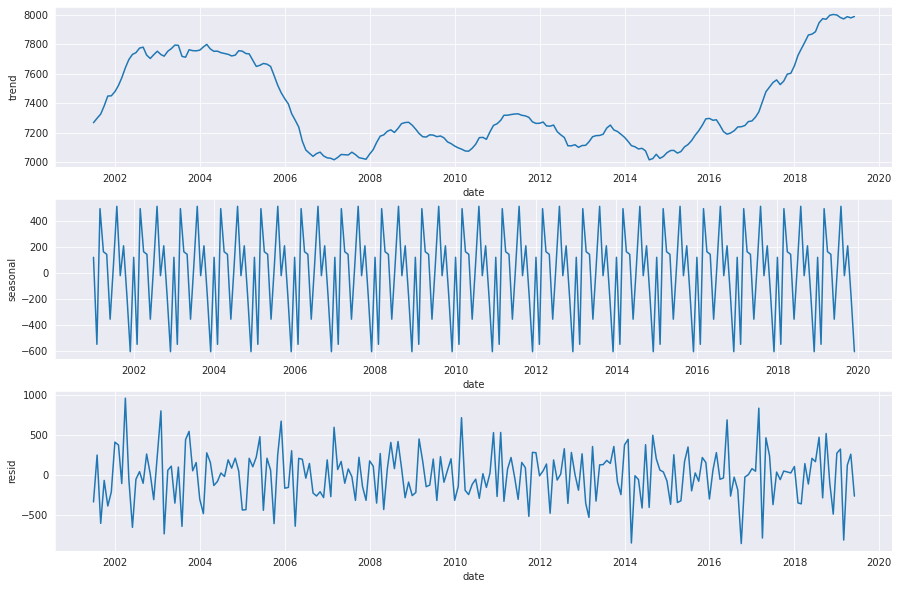

In [12]:
fig, axs = plt.subplots(3,1, figsize=(15,10),facecolor='w')

sns.lineplot(data=decomp.trend,ax=axs[0])
sns.lineplot(data=decomp.seasonal,ax=axs[1])
sns.lineplot(data=decomp.resid,ax=axs[2])

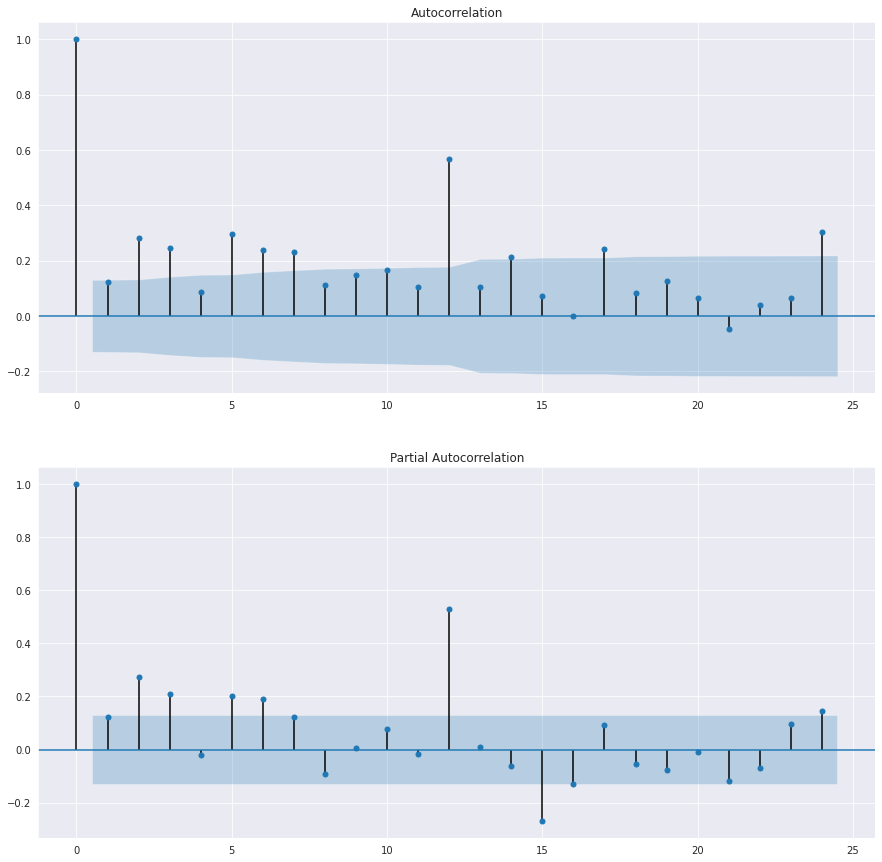

In [13]:
fig, axs = plt.subplots(2,figsize=(15,15),facecolor='w')
plot_acf(ts, ax=axs[0])
plot_pacf(ts,ax=axs[1]);

As expected, checking for autocorrelation shows the yearly pattern that we had suspected earlier.

##4.   SARIMA Model

We will try to use autoregressive integrated moving average (ARIMA) model to predict values for this series.

In [14]:
ts_train = ts[:'2018']
ts_test = ts['2019':]

In [15]:
autoarima = auto_arima(ts_train, error_action="ignore", trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3366.610, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3312.298, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3460.524, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3309.482, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3310.770, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3311.065, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3310.088, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3344.652, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3307.835, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3310.594, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3364.610, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3309.098, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [16]:
autoarima_pred = autoarima.predict(len(ts_test))
ts_test["AUTOARIMA_Prediction"] = autoarima_pred

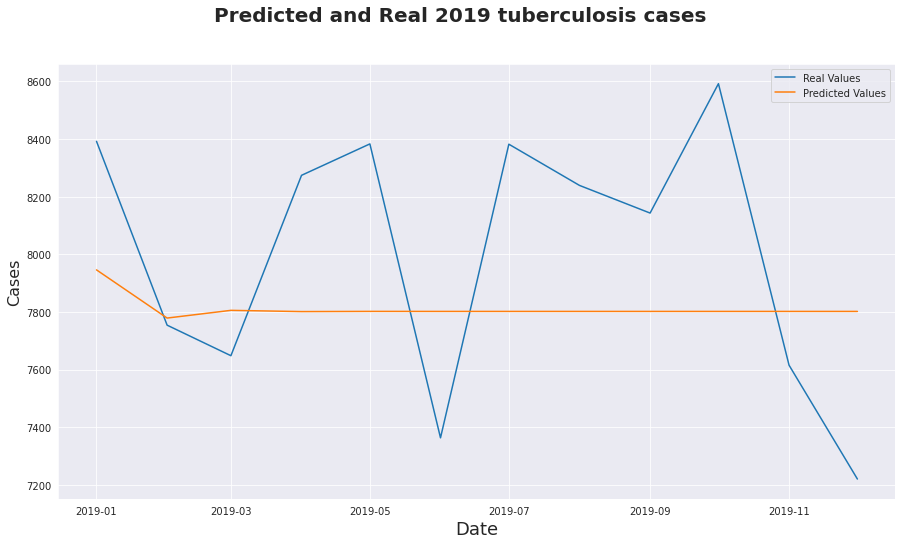

In [17]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Predicted and Real 2019 tuberculosis cases ',fontsize = 20, fontweight='bold')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Cases', fontsize=16)

sns.lineplot(x=ts_test.index, y="cases", data=ts_test,label='Real Values')
sns.lineplot(x=ts_test.index, y="AUTOARIMA_Prediction", data=ts_test,label='Predicted Values');

As show above. ARIMA model by itself doesnt show good enough results. Lets add a seasonal component each 12 months. Making this a seasonal ARIMA model (SARIMA)

In [18]:
autosarima = auto_arima(ts_train, error_action="ignore", trace=True,seasonal=True, m=12)

autosarima_pred = autosarima.predict(len(ts_test))
ts_test["AUTOSARIMA_Prediction"] = autosarima_pred

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3289.199, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3249.086, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3460.524, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3312.298, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3246.454, Time=1.85 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.11 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3398.593, Time=1.14 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3242.479, Time=2.34 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.995, Time=0.89 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3

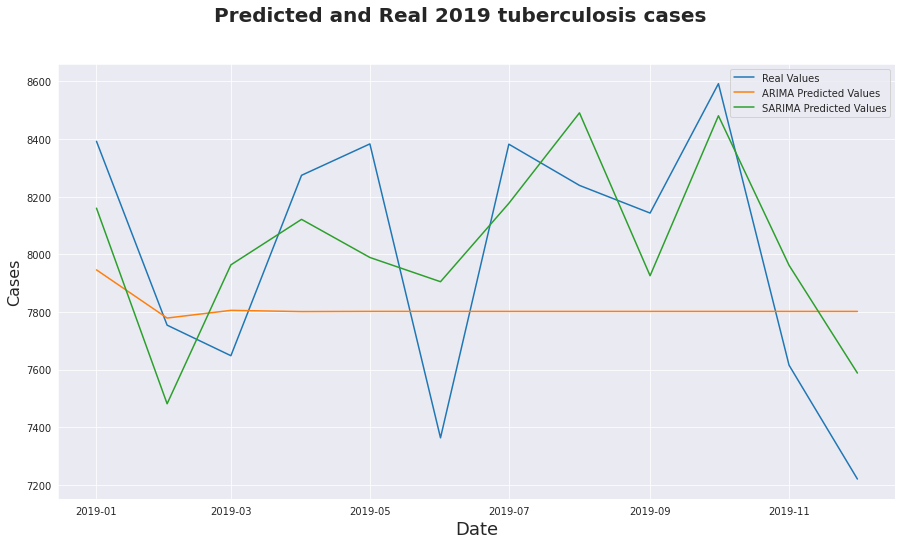

In [19]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Predicted and Real 2019 tuberculosis cases ',fontsize = 20, fontweight='bold')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Cases', fontsize=16)

sns.lineplot(x=ts_test.index, y="cases", data=ts_test,label='Real Values')
sns.lineplot(x=ts_test.index, y="AUTOARIMA_Prediction", data=ts_test,label='ARIMA Predicted Values');
sns.lineplot(x=ts_test.index, y="AUTOSARIMA_Prediction", data=ts_test,label='SARIMA Predicted Values');

We see much better results in the SARIMA Model

## 5.   Prophet Model

Now we will to model the same data with Prophet, a generalized additive model combining the trend function and seasonality function

In [20]:
prophet_model = Prophet(seasonality_mode="additive")

In [46]:
fbp_map = {"date": "ds", "cases": "y"}
ts_train_prophet = ts_train.reset_index().rename(fbp_map,axis=1) 
trained_prophet = prophet_model.fit(ts_train_prophet)

Exception: ignored

In [22]:
future_set = trained_prophet.make_future_dataframe(periods=len(ts_test), freq="MS",include_history=False)

prophet_prediction = trained_prophet.predict(future_set)

In [23]:
prophet_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,7765.233243,7379.809675,8296.906180,7765.233243,7765.233243,57.702476,57.702476,57.702476,57.702476,57.702476,57.702476,0.0,0.0,0.0,7822.935720
1,2019-02-01,7777.432692,6759.375913,7669.192707,7777.390449,7777.488743,-573.267217,-573.267217,-573.267217,-573.267217,-573.267217,-573.267217,0.0,0.0,0.0,7204.165475
2,2019-03-01,7788.451549,7709.909316,8618.955420,7788.129689,7788.887261,383.234808,383.234808,383.234808,383.234808,383.234808,383.234808,0.0,0.0,0.0,8171.686357
3,2019-04-01,7800.650998,7503.015809,8377.380572,7799.710649,7801.632710,139.653335,139.653335,139.653335,139.653335,139.653335,139.653335,0.0,0.0,0.0,7940.304333
4,2019-05-01,7812.456916,7539.992788,8482.834596,7810.844863,7814.155605,183.033973,183.033973,183.033973,183.033973,183.033973,183.033973,0.0,0.0,0.0,7995.490889
5,2019-06-01,7824.656365,6892.711588,7836.066724,7822.191838,7827.455362,-475.247313,-475.247313,-475.247313,-475.247313,-475.247313,-475.247313,0.0,0.0,0.0,7349.409051
6,2019-07-01,7836.462283,7482.639880,8426.751509,7833.192426,7840.320647,112.040038,112.040038,112.040038,112.040038,112.040038,112.040038,0.0,0.0,0.0,7948.502321
7,2019-08-01,7848.661732,7780.550157,8703.752646,7844.523100,7853.698845,378.833315,378.833315,378.833315,378.833315,378.833315,378.833315,0.0,0.0,0.0,8227.495046
8,2019-09-01,7860.861181,7384.842126,8251.838854,7855.782155,7867.345499,-37.246851,-37.246851,-37.246851,-37.246851,-37.246851,-37.246851,0.0,0.0,0.0,7823.614329
9,2019-10-01,7872.667099,7666.034909,8577.725901,7866.529081,7880.170932,244.552470,244.552470,244.552470,244.552470,244.552470,244.552470,0.0,0.0,0.0,8117.219569


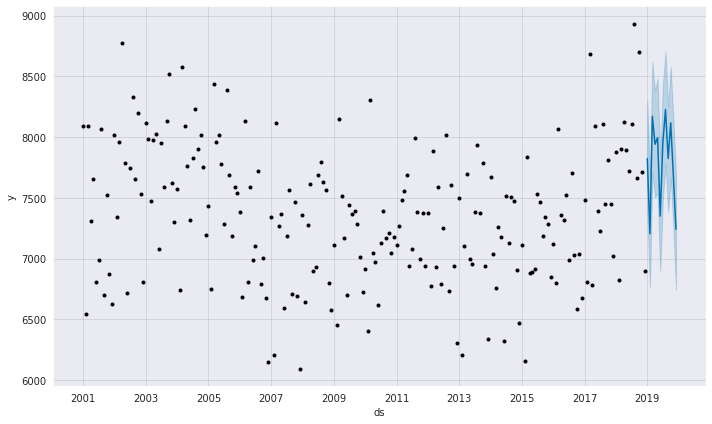

In [24]:
trained_prophet.plot(prophet_prediction);

let's use crossvalidation to check our model performance. Since Prophet doesnt allow for easy usage of non-daily datasets, lets build manual cutoff points and set the intervals for our initial training period.

In [25]:
prophet_prediction.set_index('ds',inplace=True)

ts_test['PROPHET_Prediction'] = prophet_prediction["yhat"]

In [31]:

end_initial_train = '2005-01-01' #Date to finish the initial training period. Used to calcualte param. initial
end_cutoff = '2017-12-01' #Date end training periods. Used to end cutoffs

initial = str((dt.datetime.strptime(end_initial_train,'%Y-%m-%d')-ts.index[0]).days)+' days'

cutoffs = pd.date_range(start='2005-01-01', end=end_cutoff, freq='1MS')

In [32]:
prophet_cv = cross_validation(trained_prophet,
                              initial = initial,
                              horizon='334 days',
                              cutoffs=cutoffs)

In [34]:
prophet_cvmetrics = performance_metrics(prophet_cv)

prophet_cvmetrics.info

,horizon,mse,rmse,mae,mape,mdape,coverage
0,59 days,178176.866108,422.110017,324.207173,0.044978,0.036674,0.754601
1,60 days,177486.357152,421.291297,324.449095,0.044960,0.037221,0.751534
2,61 days,165602.289272,406.942612,311.636561,0.042911,0.035544,0.763635
3,62 days,167632.461427,409.429434,315.900047,0.043728,0.035431,0.752242
4,89 days,164198.827175,405.214545,314.092408,0.043413,0.036536,0.750613
5,90 days,165548.489883,406.876504,314.216547,0.043431,0.036536,0.754601
6,91 days,169120.652239,411.242814,319.240456,0.044283,0.041368,0.751298
7,92 days,169945.875465,412.244922,319.899908,0.044350,0.036044,0.730769
8,120 days,173088.286632,416.038804,324.836812,0.044861,0.035968,0.724460
9,121 days,174554.410893,417.797093,325.042185,0.044933,0.036044,0.729870


##6.   Comparison SARIMA x Prophet

Time to compare our results between SARIMA and Prophet, visually and metrically

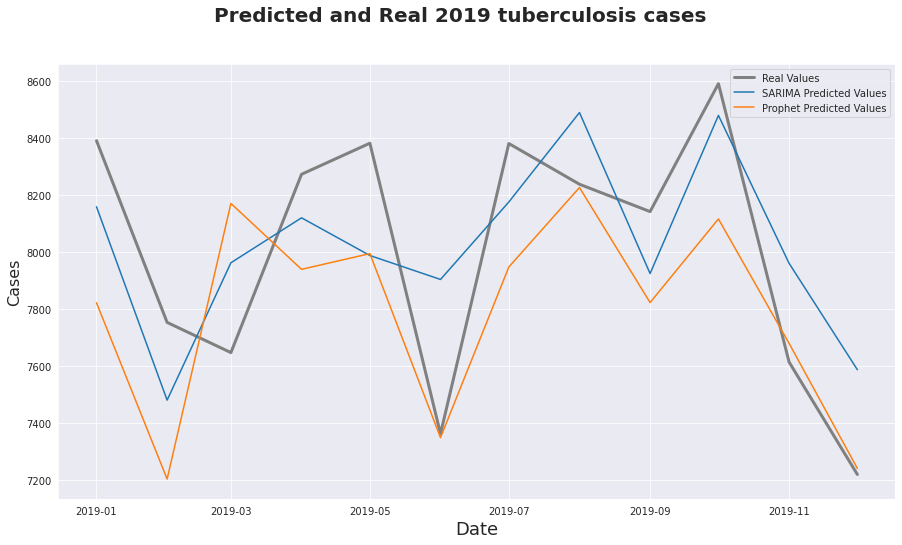

In [26]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Predicted and Real 2019 tuberculosis cases ',fontsize = 20, fontweight='bold')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Cases', fontsize=16)

sns.lineplot(x=ts_test.index, y="cases", data=ts_test,label='Real Values',color='grey',linewidth = 3)
sns.lineplot(x=ts_test.index, y="AUTOSARIMA_Prediction", data=ts_test,label='SARIMA Predicted Values')
sns.lineplot(x=ts_test.index, y="PROPHET_Prediction", data=ts_test,label='Prophet Predicted Values');

Visually it is very hard to come to a conclusion. Lets compare multiple performance metrics and see how each model performs.

In [27]:
prophet_error =  ts_test["cases"] - ts_test['PROPHET_Prediction']
sarima_error = ts_test["cases"] - ts_test['AUTOSARIMA_Prediction'] 

In [28]:
error_comparison = pd.DataFrame(columns=['Metric','Prophet','SARIMA'])

#Mean Error
mean_error = ['Mean Error',
              prophet_error.mean(),
              sarima_error.mean()]
error_comparison.loc[len(error_comparison)] = mean_error

#Mean Absolute Error
mean_absolute_error = ['Mean Absolute Error',
              abs(prophet_error).mean(),
              abs(sarima_error).mean()]
error_comparison.loc[len(error_comparison)] = mean_absolute_error

#Mean Squared Error
mean_squared_error = ['Mean Squared Error',
              (prophet_error**2).mean(),
             (sarima_error**2).mean()]
error_comparison.loc[len(error_comparison)] = mean_squared_error

#Root Mean Squared Error
root_mean_squared_error = ['Root Mean Squared Error',
              sqrt((prophet_error**2).mean()),
              sqrt((sarima_error**2).mean())]
error_comparison.loc[len(error_comparison)] = root_mean_squared_error

error_comparison.set_index('Metric',inplace=True)
error_comparison['Best_Model'] = error_comparison.apply(lambda x: error_comparison.columns[x.argmin()], axis = 1)

error_comparison

,Prophet,SARIMA,Best_Model
Metric,,,
Mean Error,206.864055,-19.791528,SARIMA
Mean Absolute Error,308.613156,284.099473,SARIMA
Mean Squared Error,140194.286124,93378.932858,SARIMA
Root Mean Squared Error,374.425274,305.579667,SARIMA
Mean Absolute Percent Error,97.544239,100.411391,Prophet
Median Absolute Percent Error,96.022363,98.428208,Prophet


We see SARIMA with a better performance in general. But with some tuning of the Hyperparameters, Prophet may perform better

##7.   Prophet Hyperparameters Tuning

We will use a very simple (and long) method for searching better parameters for Prophet. We will build a list of all parametere we wish to try and simple train all possible combination. Let this run overnight and enjoy Google Colab's free CPU. The Prophet Parameters we will play with are:

*   Growth
*   changepoint prior scale
*   changepoint range
*   seasonality prior scale
*   holidays_prior_scale
*   yearly_seasonality
*   weekly_seasonality
*   seasonality_mode




In [41]:
def param_comb(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df


In [42]:
def run_cv(df, metrics, param_dict):
    prophet_model = Prophet(**param_dict)
    prophet_model.fit(df)
    df_cv = cross_validation(prophet_model, initial = initial, horizon='334 days',cutoffs=cutoffs)
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [48]:
param_grid = {  
                'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                'holidays_prior_scale':[0, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'yearly_seasonality': [0, 10, 20]
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []

In [49]:
params_df = param_comb(**param_grid)

In [ ]:
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = run_cv(ts_train_prophet,  metrics, param_dict)
    results.append(cv_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df

##8.   Comparison SARIMA x Tuned Prophet

New we will see how the Tuned Prophet model compares to the SARIMA model

Given this, we can see that better model seems to be _______________________________

##9.   My 2020 predictions

Given all this, here are my predictions for the 2020 incidence of Tuberculosis in Brazil. Later this year i'll update this notebook with the real result